# Using RL to Model Cognitive Tasks

**By Neurmatch Academy**

__Content creators:__ Morteza Ansarinia, Yamil Vidal

__Production editor:__ Spiros Chavlis


<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Objective

- This project aims to use behavioral data to train an agent and then use the agent to investigate data produced by human subjects. Having a computational agent that mimics humans in such tests, we will be able to compare its mechanics with human data.

- In another conception, we could fit an agent that learns many cognitive tasks that require abstract-level constructs such as executive functions. This is a multi-task control problem.




---
# Setup

In [1]:
# @title Install dependencies
# !pip install --upgrade pip setuptools wheel --quiet
!pip install dm-acme[jax,tensorflow] --quiet
!pip install dm-acme[envs] --quiet
!pip install dm-sonnet --quiet
!pip install trfl --quiet

In [2]:
# Imports

import time
import numpy as np
import pandas as pd
import sonnet as snt
import seaborn as sns
import matplotlib.pyplot as plt

import dm_env

import acme
from acme import specs
from acme import wrappers
from acme import EnvironmentLoop
from acme.agents.tf import dqn
from acme.utils import loggers

In [3]:
# @title Figure settings
from IPython.display import clear_output, display, HTML
%matplotlib inline
sns.set()

---
# Background

- Cognitive scientists use standard lab tests to tap into specific processes in the brain and behavior. Some examples of those tests are Stroop, N-back, Digit Span, TMT (Trail making tests), and WCST (Wisconsin Card Sorting Tests).

- Despite an extensive body of research that explains human performance using descriptive what-models, we still need a more sophisticated approach to gain a better understanding of the underlying processes (i.e., a how-model).

- Interestingly, many of such tests can be thought of as a continuous stream of stimuli and corresponding actions, that is in consonant with the RL formulation. In fact, RL itself is in part motivated by how the brain enables goal-directed behaviors using reward systems, making it a good choice to explain human performance.

- One behavioral test example would be the N-back task.

  - In the N-back, participants view a sequence of stimuli, one by one, and are asked to categorize each stimulus as being either match or non-match. Stimuli are usually numbers, and feedback is given at both timestep and trajectory levels.

  - The agent is rewarded when its response matches the stimulus that was shown N steps back in the episode. A simpler version of the N-back uses two-choice action schema, that is match vs non-match. Once the present stimulus matches the one presented N step back, then the agent is expected to respond to it as being a `match`.


- Given a trained RL agent, we then find correlates of its fitted parameters with the brain mechanisms. The most straightforward composition could be the correlation of model parameters with the brain activities.

## Datasets

- HCP WM task ([NMA-CN HCP notebooks](https://github.com/NeuromatchAcademy/course-content/tree/master/projects/fMRI))

Any dataset that used cognitive tests would work.
Question: limit to behavioral data vs fMRI?
Question: Which stimuli and actions to use?
classic tests can be modeled using 1) bounded symbolic stimuli/actions (e.g., A, B, C), but more sophisticated one would require texts or images (e.g., face vs neutral images in social stroop dataset)
The HCP dataset from NMA-CN contains behavioral and imaging data for 7 cognitive tests including various versions of N-back.

## N-back task

In the N-back task, participants view a sequence of stimuli, one per time, and are asked to categorize each stimulus as being either match or non-match. Stimuli are usually numbers, and feedbacks are given at both timestep and trajectory levels.

In a typical neuro setup, both accuracy and response time are measured, but here, for the sake of brevity, we focus only on accuracy of responses.

---
# Cognitive Tests Environment

First we develop an environment in that agents perform a cognitive test, here the N-back.

## Human dataset

We need a dataset of human perfoming a N-back test, with the following features:

- `participant_id`: following the BIDS format, it contains a unique identifier for each participant.
- `trial_index`: same as `time_step`.
- `stimulus`: same as `observation`.
- `response`: same as `action`, recorded response by the human subject.
- `expected_response`: correct response.
- `is_correct`: same as `reward`, whether the human subject responded correctly.
- `response_time`: won't be used here.

Here we generate a mock dataset with those features, but remember to **replace this with real human data.**

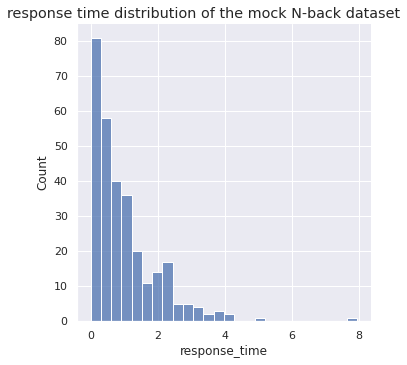

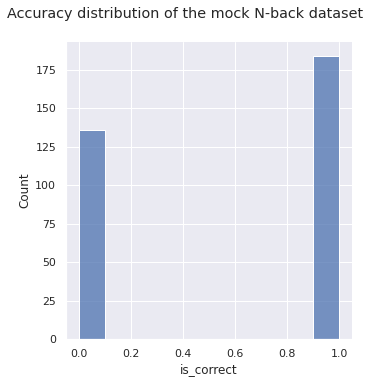

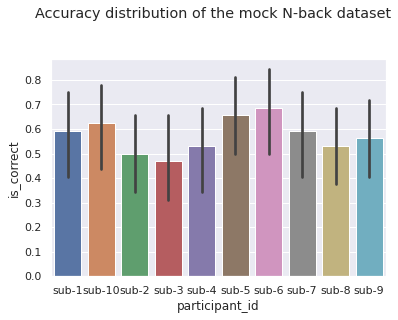

,participant_id,trial_index,stimulus,response,response_time,expected_response,is_correct
0,sub-1,1,E,None,NaN,None,1
1,sub-1,2,B,None,NaN,None,1
2,sub-1,3,E,match,0.019583,match,1
3,sub-1,4,C,match,0.547426,non-match,0
4,sub-1,5,F,non-match,0.059307,non-match,1


In [4]:
def generate_mock_nback_dataset(N=2,
                                n_participants=10,
                                n_trials=32,
                                stimulus_choices=list('ABCDEF'),
                                response_choices=['match', 'non-match']):
  """Generate a mock dataset for the N-back task."""

  n_rows = n_participants * n_trials

  participant_ids = sorted([f'sub-{pid}' for pid in range(1, n_participants + 1)] * n_trials)
  trial_indices = list(range(1, n_trials + 1)) * n_participants
  stimulus_sequence = np.random.choice(stimulus_choices, n_rows)

  responses = np.random.choice(response_choices, n_rows)
  response_times = np.random.exponential(size=n_rows)

  df = pd.DataFrame({
      'participant_id': participant_ids,
      'trial_index': trial_indices,
      'stimulus': stimulus_sequence,
      'response': responses,
      'response_time': response_times
  })

  # mark matchig stimuli
  _nback_stim = df['stimulus'].shift(N)
  df['expected_response'] = (df['stimulus'] == _nback_stim).map({True: 'match', False: 'non-match'})

  df['is_correct'] = (df['response'] == df['expected_response'])

  # we don't care about burn-in trials (trial < N)
  df.loc[df['trial_index'] <= N, 'is_correct'] = True
  df.loc[df['trial_index'] <= N, ['response', 'response_time', 'expected_response']] = None

  return df


# ========
# now generate the actual data with the provided function and plot some of its features
mock_nback_data = generate_mock_nback_dataset()
mock_nback_data['is_correct'] = mock_nback_data['is_correct'].astype(int)

sns.displot(data=mock_nback_data, x='response_time')
plt.suptitle('response time distribution of the mock N-back dataset', y=1.01)
plt.show()

sns.displot(data=mock_nback_data, x='is_correct')
plt.suptitle('Accuracy distribution of the mock N-back dataset', y=1.06)
plt.show()

sns.barplot(data=mock_nback_data, y='is_correct', x='participant_id')
plt.suptitle('Accuracy distribution of the mock N-back dataset', y=1.06)
plt.show()

mock_nback_data.head()

## Implementation scheme


### Environment

The following cell implments N-back envinronment, that we later use to train a RL agent on human data. It is capable of performing two kinds of simulation:
- rewards the agent once the action was correct (i.e., a normative model of the environment).
- receives human data (or mock data if you prefer), and returns what participants performed as the observation. This is more useful for preference-based RL.

In [34]:
class NBack(dm_env.Environment):

  ACTIONS = ['match', 'non-match']

  def __init__(self,
               N=2,
               episode_steps=32,
               stimuli_choices=list('ABCDEF'),
               human_data=None,
               seed=1,
               ):
    """
    Args:
      N: Number of steps to look back for the matched stimuli. Defaults to 2 (as in 2-back).
      episode_steps
      stimuli_choices
      human_data
      seed

    """
    # N back =2
    self.N = N
    # Number of episode steps = 32
    self.episode_steps = episode_steps
    # Stimuli choices = 0,1,2,3,4,5
    self.stimuli_choices = stimuli_choices
    # Stimuli - vector of size 32
    self.stimuli = np.empty(shape=episode_steps)  # will be filled in the `reset()`
    
    self.n_s = len(self.stimuli_choices)
    self.prob = 0.5 * (self.n_s - 2)/ (self.n_s - 1)


    self._reset_next_step = True

    # whether mimic humans or reward the agent once it responds optimally.
    if human_data is None:
      self._imitate_human = False
      self.human_data = None
      self.human_subject_data = None
    else:
      self._imitate_human = True
      self.human_data = human_data
      self.human_subject_data = None

    # Action History is a plank vector
    self._action_history = []

  def reset(self):
    self._reset_next_step = False
    self._current_step = 0
    self._action_history.clear()

    # generate a random sequence instead of relying on human data
    # generates an entire random sequence of 32 stimuli [................................]
    if self.human_data is None:
      # self.stimuli = np.random.choice(self.stimuli_choices, self.episode_steps)
      # FIXME This is a fix for acme & reverb issue with string observation. Agent should be able to handle strings
      #self.stimuli = np.random.choice(len(self.stimuli_choices), self.episode_steps).astype(np.float32)
      #self.stimuli = np.random.choice(len(self.stimuli_choices)).astype(np.float32)
      #print("self.stimuli", self.stimuli)

      self.stimuli=np.ones(self.episode_steps)
      # match prob will be slightly higher than non-match prob
      for i in range(self.episode_steps):
          if i<self.N:
            self.stimuli[i]=np.random.choice(self.n_s)
          else:
            rand=np.random.random()
            if rand < self.prob:
              self.stimuli[i]=self.stimuli[i-self.N]
            else:
              self.stimuli[i]=np.random.choice(self.n_s)

   
    else:
      # randomly choose a subject from the human data and follow her trials and responses.
      # FIXME should we always use one specific human subject or randomly select one in each episode?
      self.human_subject_data = self.human_data.query('participant_id == participant_id.sample().iloc[0]',
                                                engine='python').sort_values('trial_index')
      self.stimuli = self.human_subject_data['stimulus'].to_list()
      self.stimuli = np.array([ord(s) - ord('A') + 1 for s in self.stimuli]).astype(np.float32)

    # return the observation 
    return dm_env.restart(self._observation())


  def _episode_return(self):
    if self._imitate_human:
      return np.mean(self.human_subject_data['response'] == self._action_history)
    else:
      return 0.0

  def step(self, action: int):
    if self._reset_next_step:
      return self.reset()

    agent_action = NBack.ACTIONS[action]
    #print("Step action" , agent_action)

    if self._imitate_human:
      # if it was the same action as the human subject, then reward the agent
      human_action = self.human_subject_data['response'].iloc[self._current_step]
      step_reward = 0. if (agent_action == human_action) else -1.
    else:
      # assume the agent is rationale and doesn't want to reproduce human, reward once the response it correct
      # gives a reward based on the action chosen by the agent but it has access to all the stimuli 
      #print("Current Stimuli for reward", self.stimuli[self._current_step])
      expected_action = 'match' if (self.stimuli[self._current_step] == self.stimuli[self._current_step - self.N]) else 'non-match'
      step_reward = 0. if (agent_action == expected_action) else -1.

      print("\nCurrent Step", self._current_step)
      print(" Stimulus current step",self.stimuli[self._current_step])
      print(" Stimulus two steps back",self.stimuli[self._current_step - self.N])
      print("action action", agent_action)
      print("Expected action", expected_action)
      print("step_reward",step_reward)

    self._action_history.append(agent_action)

    self._current_step += 1

    # Check for termination.
    if self._current_step == self.stimuli.shape[0]:
      self._reset_next_step = True
      # we are using the mean of total time step rewards as the episode return
      return dm_env.termination(reward=self._episode_return(),
                                observation=self._observation())
    else:
      return dm_env.transition(reward=step_reward,
                               observation=self._observation())

  def observation_spec(self):
    return dm_env.specs.BoundedArray(
        shape=self.stimuli[0].shape,
        dtype=self.stimuli[0].dtype,
        name='nback_stimuli', minimum=0, maximum=len(self.stimuli_choices)+ 1)

  def action_spec(self):
    return dm_env.specs.DiscreteArray(
        num_values=len(NBack.ACTIONS),
        dtype=np.int32,
        name='action')

  def _observation(self):

    # agent observes only the current trial
    #print("\nCurrent Step",self._current_step)

    if self._current_step ==  self.episode_steps:
      obs = self.stimuli[0]
    else:
      obs = self.stimuli[self._current_step]
    print("Observation agent sees",obs)
    # agents observe stimuli up to the current trial
    #obs = self.stimuli[:self._current_step+1].copy()
    #obs = np.pad(obs,(0, len(self.stimuli) - len(obs)))
  
    return obs

  def plot_state(self):
    """Display current state of the environment.

     Note: `M` mean `match`, and `.` is a `non-match`.
    """
    stimuli = self.stimuli[:self._current_step - 1]
    actions = ['M' if a=='match' else '.' for a in self._action_history[:self._current_step - 1]]
    return HTML(
        f'<b>Environment ({self.N}-back):</b><br />'
        f'<pre><b>Stimuli:</b> {"".join(map(str,map(int,stimuli)))}</pre>'
        f'<pre><b>Actions:</b> {"".join(actions)}</pre>'
    )

  @staticmethod
  def create_environment():
    """Utility function to create a N-back environment and its spec."""

    # Make sure the environment outputs single-precision floats.
    environment = wrappers.SinglePrecisionWrapper(NBack())

    # Grab the spec of the environment.
    environment_spec = specs.make_environment_spec(environment)

    return environment, environment_spec

### Define a random agent

For more information you can refer to NMA-DL W3D2 Basic Reinforcement learning.

In [35]:
class RandomAgent(acme.Actor):

  def __init__(self, environment_spec):
    """Gets the number of available actions from the environment spec."""
    self._num_actions = environment_spec.actions.num_values

  def select_action(self, observation):
    """Selects an action uniformly at random."""
    action = np.random.randint(self._num_actions)
    return action

  def observe_first(self, timestep):
    """Does not record as the RandomAgent has no use for data."""
    pass

  def observe(self, action, next_timestep):
    """Does not record as the RandomAgent has no use for data."""
    pass

  def update(self):
    """Does not update as the RandomAgent does not learn from data."""
    pass

### Initialize the environment and the agent

In [36]:
env, env_spec = NBack.create_environment()
agent = RandomAgent(env_spec)

print('actions:\n', env_spec.actions)
print('observations:\n', env_spec.observations)
print('rewards:\n', env_spec.rewards)

actions:
 DiscreteArray(shape=(), dtype=int32, name=action, minimum=0, maximum=1, num_values=2)
observations:
 BoundedArray(shape=(), dtype=dtype('float32'), name='nback_stimuli', minimum=0.0, maximum=7.0)
rewards:
 Array(shape=(), dtype=dtype('float32'), name='reward')


### Run the loop

For more details, see NMA-DL W3D2.

Observation agent sees 4.0

Current Step 0
 Stimulus current step 4.0
 Stimulus two steps back 1.0
action action match
Expected action non-match
step_reward -1.0
Observation agent sees 5.0

Current Step 1
 Stimulus current step 5.0
 Stimulus two steps back 1.0
action action non-match
Expected action non-match
step_reward 0.0
Observation agent sees 2.0

Current Step 2
 Stimulus current step 2.0
 Stimulus two steps back 4.0
action action non-match
Expected action non-match
step_reward 0.0
Observation agent sees 1.0

Current Step 3
 Stimulus current step 1.0
 Stimulus two steps back 5.0
action action match
Expected action non-match
step_reward -1.0
Observation agent sees 2.0

Current Step 4
 Stimulus current step 2.0
 Stimulus two steps back 2.0
action action match
Expected action match
step_reward 0.0
Observation agent sees 1.0

Current Step 5
 Stimulus current step 1.0
 Stimulus two steps back 1.0
action action match
Expected action match
step_reward 0.0
Observation agent sees 2.0

Curr

{'episode': 0, 'episode_length': 32, 'episode_return': -9.0}


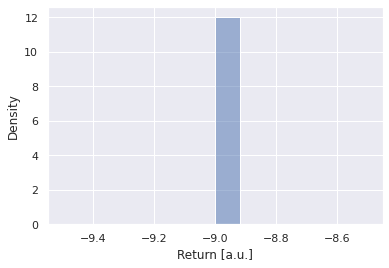

In [37]:
# fitting parameters
n_episodes = 1
n_total_steps = 0
log_loss = False
n_steps = n_episodes * 32
all_returns = []

# main loop
for episode in range(n_episodes):
  episode_steps = 0
  episode_return = 0
  episode_loss = 0

  start_time = time.time()

  timestep = env.reset() 

  # Make the first observation.
  agent.observe_first(timestep)

  # Run an episode
  while not timestep.last():

    # DEBUG
    # print(timestep)

    # Generate an action from the agent's policy and step the environment.
    #print("get observation", timestep.observation)
    action = agent.select_action(timestep.observation)
    #action = 0
    #print("get action:", action)
    timestep = env.step(action)
    #print("take a step")

    # Have the agent observe the timestep and let the agent update itself.
    agent.observe(action, next_timestep=timestep)
    #print("timestep", timestep)
    agent.update()
  

    # Book-keeping.
    episode_steps += 1
    n_total_steps += 1
    episode_return += timestep.reward

    if log_loss:
      episode_loss += agent.last_loss

    if n_steps is not None and n_total_steps > n_steps:
      break

  # Collect the results and combine with counts.
  steps_per_second = episode_steps / (time.time() - start_time)
  result = {
      'episode': episode,
      'episode_length': episode_steps,
      'episode_return': episode_return,
  }
  if log_loss:
    result['loss_avg'] = episode_loss/episode_steps

  all_returns.append(episode_return)

  display(env.plot_state())
  # Log the given results.
  print(result)

  if n_steps is not None and n_total_steps >= n_steps:
    break

#clear_output()

# Histogram of all returns
plt.figure()
sns.histplot(all_returns, stat="density", kde=True, bins=12)
plt.xlabel('Return [a.u.]')
plt.ylabel('Density')
plt.show()

#Stimuli: 5121131340040444144500400034314
#Actions: .M.M.M.MMMM..M..M.......MMMMM.M

**Note:** You can simplify the environment loop using [DeepMind Acme](https://github.com/deepmind/acme).

In [9]:
# init a new N-back environment
env, env_spec = NBack.create_environment()

# DEBUG fake testing environment.
# Uncomment this to debug your agent without using the N-back environment.
# env = fakes.DiscreteEnvironment(
#     num_actions=2,
#     num_observations=1000,
#     obs_dtype=np.float32,
#     episode_length=32)
# env_spec = specs.make_environment_spec(env)

In [10]:
def dqn_make_network(action_spec: specs.DiscreteArray) -> snt.Module:
  return snt.Sequential([
      snt.Flatten(),
      snt.nets.MLP([50, 50, action_spec.num_values]),
  ])

# construct a DQN agent
agent = dqn.DQN(
    environment_spec=env_spec,
    network=dqn_make_network(env_spec.actions),
    epsilon=[0.5],
    learning_rate = 1e-5,
    logger=loggers.InMemoryLogger(),
    checkpoint=False,
)

Now, we run the environment loop with the DQN agent and print the training log.

In [ ]:
# training loop
loop = EnvironmentLoop(env, agent, logger=loggers.InMemoryLogger())
loop.run(n_episodes)

# print logs
logs_dqn = pd.DataFrame(loop._logger._data)
logs_dqn.tail()
env.plot_state()

In [ ]:
logs_dqn.tail()

DRQN AGENT

In [ ]:
from acme.agents.tf import r2d2
def r2d2_make_network(action_spec: specs.DiscreteArray) -> snt.Module:
  return snt.DeepRNN([
            snt.Flatten(),
            snt.LSTM(2),
            snt.nets.MLP([50, 50, action_spec.num_values])
            ])

agent_r2d2 = r2d2.R2D2(
    environment_spec=env_spec,
    network=r2d2_make_network(env_spec.actions),
    learning_rate = 1e-5,
    burn_in_length=10,
    trace_length=2,
    replay_period=10,
    epsilon=[0.1],
    logger=loggers.InMemoryLogger(),
    checkpoint=False,
)

loop = EnvironmentLoop(env, agent_r2d2, logger=loggers.InMemoryLogger())
loop.run(n_episodes)

# print logs
logs_r2d2 = pd.DataFrame(loop._logger._data)
logs_r2d2.tail()

In [ ]:
def moving_average(interval, window_size):
    window = np.ones(int(window_size)) / float(window_size)
    return np.convolve(interval, window, 'same')  
r2d2_ma=moving_average(logs_r2d2['episode_return'],10)
dqn_ma=moving_average(logs_dqn['episode_return'],10)

plt.plot(r2d2_ma)
plt.plot(dqn_ma)
#plt.plot(all_returns)

plt.ylabel("episode_reward")
plt.xlabel("episode (N_steps per episode = 100)")
plt.legend(['DRQN','DQN','RANDOM'])